# Water Risk Classification: Data Wrangling

## Setup

In [68]:
import pandas as pd
import geopandas as gpd
import requests, zipfile, io, os, tarfile
from matplotlib import pyplot
import rasterio as rio
from rasterio import plot
from rasterstats import zonal_stats
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray # for the extension to load
import xarray
from matplotlib import pyplot as plt
%matplotlib inline


## Download Data
**ONLY RUN IF YOU DON'T HAVE THE DATA FOLDER YET. IT WILL TAKE A LONG TIME.**

Download and unzip all the datasets. 

In [2]:
# create data folder
os.mkdir('./data')

In [4]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_aq = 'https://wri-projects.s3.amazonaws.com/Aqueduct30/finalData/Y2019M07D12_Aqueduct30_V01.zip'

r = requests.get(url_aq) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data') # unzip into data subdirectory

In [5]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_ghs = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_SMOD_POP_GLOBE_R2019A/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K/V1-0/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.zip'

r = requests.get(url_ghs) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/ghs') # unzip into data subdirectory

In [10]:
# This download requires useer authentication and isn't currently working
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_inf_mort = 'https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip'

r = requests.get(url_inf_mort) # download zipped directory
z = zipfile.ZipFile("./data/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip") # create zipfile object
z.extractall(path='data/sedac') # unzip into data subdirectory
z.close()

In [34]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_light = 'https://ngdc.noaa.gov/eog/data/web_data/v4avg_lights_x_pct/F182013.v4c.avg_lights_x_pct.tgz'

r = requests.get(url_light, allow_redirects=True)
open('./data/F182013.v4c.avg_lights_x_pct.tgz', 'wb').write(r.content)

KeyboardInterrupt: 

In [38]:
temp_path = './data/F182013.v4c.avg_lights_x_pct.tgz'

z = tarfile.open(temp_path, mode='r:gz') # create zipfile object
z.extractall(path='data/light') # unzip into data subdirectory
z.close()

os.remove(temp_path)

## Load Data

WRI Aqueduct metadata with column name explanations is available [here](https://github.com/wri/aqueduct30_data_download/blob/master/metadata.md).

In [36]:
path_aq = './data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg'

aq = gpd.read_file(path_aq, layer='y2019m07d11_aqueduct30_annual_v01')

aq.head()

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_score,w_awr_tex_rrr_cat,w_awr_tex_rrr_label,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...


In [4]:
path_ghs = './data/ghs/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.tif'

ghs = rio.open(path_ghs)

In [5]:
path_inf_mort = './data/sedac/povmap_global_subnational_infant_mortality_rates_v2.tif'

inf_mort = rio.open(path_inf_mort)

In [6]:
# This codeblock doesn't run bc of error below
# RasterioIOError: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff.
path_light1 = './data/light/F182013.v4c.avg_lights_x_pct.tif'
path_light2 = './data/light/F182013.v4c.pct_lights.tif'

light1 = rio.open(path_light1)
light2 = rio.open(path_light2)

RasterioIOError: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff.

## Explore Data

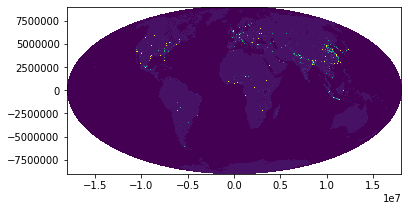

({'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -200.0,
  'width': 36082,
  'height': 18000,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
  'transform': Affine(1000.0, 0.0, -18041000.0,
         0.0, -1000.0, 9000000.0)},
 <matplotlib.axes._subplots.AxesSubplot at 0x18ec0d4b0b8>)

In [7]:
ghs.meta,plot.show(ghs)

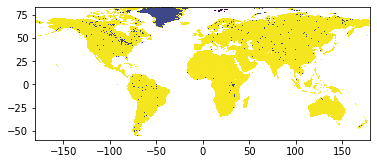

({'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': -1.7976931348623157e+308,
  'width': 43200,
  'height': 17173,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.00833333333333333, 0.0, -179.99999999999997,
         0.0, -0.00833333333333333, 83.62711161733333)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1eeabdc8ac8>)

In [9]:
inf_mort.meta,plot.show(inf_mort)

In [17]:
# check crs
aq.crs, aq.crs == ghs.crs, aq.crs == inf_mort.crs

({'init': 'epsg:4326'}, False, True)

In [31]:
# code from https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/
transform, width, height = calculate_default_transform(
        ghs.crs, aq.crs, ghs.width, ghs.height, *ghs.bounds)
metacopy = ghs.meta.copy()
metacopy.update({
        'crs': aq.crs,
        'transform': transform,
        'width': width,
        'height': height})

ghsr = reproject(source=ghs,
                 destination=ghs,
                 src_transform=ghs.transform,
                 src_crs=ghs.crs,
                 dst_transform=transform,
                 dst_crs=aq.crs,
                 resampling=Resampling.nearest)

ValueError: Invalid source

In [32]:
ghs.to_crs({'init':'epsg:4326'})

AttributeError: 'DatasetReader' object has no attribute 'to_crs'

In [34]:
ghs.crs.data

{'proj': 'moll',
 'lon_0': 0,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

## Join Data

In [47]:
aq.geometry.type

0        MultiPolygon
1        MultiPolygon
2        MultiPolygon
3        MultiPolygon
4        MultiPolygon
             ...     
68501    MultiPolygon
68502    MultiPolygon
68503    MultiPolygon
68504    MultiPolygon
68505    MultiPolygon
Length: 68506, dtype: object

In [52]:
# I initially thought the aggregation was not working because the aquifer dataset's rows are multipolygons
# So I exploded them, but still the zonal stats do not work
# I left the code here, becauase it may be useful later
# got it from: https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indata):
    indf = gpd.GeoDataFrame.from_file(indata)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

In [61]:
aq2 = aq.explode()

In [62]:
# the dataset increases from 68k to 522k rows
aq2

string_id  aq30_id  pfaf_id     gid_1  aqid gid_0  \
0     0  111011-EGY.11_1-3365        0   111011  EGY.11_1  3365   EGY   
1     0  111011-EGY.15_1-3365        1   111011  EGY.15_1  3365   EGY   
2     0  111011-EGY.15_1-None        2   111011  EGY.15_1 -9999   EGY   
      1  111011-EGY.15_1-None        2   111011  EGY.15_1 -9999   EGY   
      2  111011-EGY.15_1-None        2   111011  EGY.15_1 -9999   EGY   
...                       ...      ...      ...       ...   ...   ...   
68501 0     None-YEM.5_1-None    68506    -9999   YEM.5_1 -9999   YEM   
68502 0     None-ZAF.1_1-None    68507    -9999   ZAF.1_1 -9999   ZAF   
68503 0     None-ZAF.4_1-None    68508    -9999   ZAF.4_1 -9999   ZAF   
68504 0     None-ZAF.9_1-2940    68509    -9999   ZAF.9_1  2940   ZAF   
68505 0     None-ZAF.9_1-None    68510    -9999   ZAF.9_1 -9999   ZAF   

               name_0         name_1     area_km2   bws_raw  ...  \
0     0         Egypt     Al Qahirah     4.223754  2.318042  ...   
1     0         Egypt      As Suways  1846.012343  2.318042  ...   
2     0         Egypt      As Suways    30.526067  2.318042  ...   
      1         Egypt      As Suways    30.526067  2.318042  ...   
      2         Egypt      As Suways    30.526067  2.318042  ...   
...               ...            ...          ...       ...  ...   
68501 0         Yemen    Al Hudaydah     0.887022       NaN  ...   
68502 0  South Africa   Eastern Cape     0.019523       NaN  ...   
68503 0  South Africa  KwaZulu-Natal     0.085616       NaN  ...   
68504 0  South Africa   Western Cape     0.015411       NaN  ...   
68505 0  South Africa   Western Cape     0.449872       NaN  ...   

         w_awr_tex_rrr_score  w_awr_tex_rrr_cat   w_awr_tex_rrr_label  \
0     0             2.165272                2.0   Medium - High (2-3)   
1     0             2.165272                2.0   Medium - High (2-3)   
2     0             2.165272                2.0   Medium - High (2-3)   
      1             2.165272                2.0   Medium - High (2-3)   
      2             2.165272                2.0   Medium - High (2-3)   
...                      ...                ...                   ...   
68501 0             4.626502                4.0  Extremely High (4-5)   
68502 0             2.177403                2.0   Medium - High (2-3)   
68503 0             2.177403                2.0   Medium - High (2-3)   
68504 0             2.177403                2.0   Medium - High (2-3)   
68505 0             2.177403                2.0   Medium - High (2-3)   

         w_awr_tex_rrr_weight_fraction  w_awr_tex_tot_raw  \
0     0                       0.326531           2.457171   
1     0                       0.326531           2.457171   
2     0                       0.326531           2.457171   
      1                       0.326531           2.457171   
      2                       0.326531           2.457171   
...                                ...                ...   
68501 0                       0.163265           4.277528   
68502 0                       0.163265           1.822667   
68503 0                       0.163265           1.822667   
68504 0                       0.163265           1.822667   
68505 0                       0.163265           1.822667   

         w_awr_tex_tot_score w_awr_tex_tot_cat   w_awr_tex_tot_label  \
0     0             3.614603               3.0            High (3-4)   
1     0             3.614603               3.0            High (3-4)   
2     0             3.614603               3.0            High (3-4)   
      1             3.614603               3.0            High (3-4)   
      2             3.614603               3.0            High (3-4)   
...                      ...               ...                   ...   
68501 0             4.688755               4.0  Extremely High (4-5)   
68502 0             2.430366               2.0   Medium - High (2-3)   
68503 0             2.430366               2.0   Medium - High (2-3)

In [66]:
inf_mort.transform

Affine(0.00833333333333333, 0.0, -179.99999999999997,
       0.0, -0.00833333333333333, 83.62711161733333)

In [76]:
inf_mort_array = inf_mort.read(1)

In [77]:
mortality_stats = zonal_stats(aq, inf_mort_array, affine = inf_mort.transform, stats = ['mean', 'median', 'sum'])
mortality_stats

C:\Users\leoha\Anaconda\envs\musa-620\lib\site-packages\rasterstats\io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Users\leoha\Anaconda\envs\musa-620\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\leoha\Anaconda\envs\musa-620\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[{'mean': 34.69315068493151,
  'sum': 173.46575342465755,
  'median': 34.69315068493151},
 {'mean': 14.868493150684936,
  'sum': 36650.835616438366,
  'median': 14.868493150684934},
 {'mean': -inf, 'sum': -inf, 'median': 14.868493150684934},
 {'mean': 14.868493150684934,
  'sum': 14.868493150684934,
  'median': 14.868493150684934},
 {'mean': -inf, 'sum': -inf, 'median': 14.868493150684934},
 {'mean': 34.69315068493152,
  'sum': 12073.216438356167,
  'median': 34.69315068493151},
 {'mean': 14.937066853674374,
  'sum': 43183.06027397262,
  'median': 14.868493150684934},
 {'mean': -8.988465674311579e+307,
  'sum': -1.7976931348623157e+308,
  'median': -8.988465674311579e+307},
 {'mean': 34.69315068493152,
  'sum': 23695.421917808224,
  'median': 34.69315068493151},
 {'mean': None, 'median': None, 'sum': None},
 {'mean': -inf, 'sum': -inf, 'median': 14.868493150684934},
 {'mean': 14.868493150684936,
  'sum': 74.34246575342468,
  'median': 14.868493150684934},
 {'mean': 14.207671232876715,


In [78]:
# instead of repreojecting the raster, I reprojected the aquifer data to the ghs crs
aq3 = aq.to_crs(ghs.crs.data)

In [79]:
ghs_array = ghs.read(1)

In [80]:
ghs_stats = zonal_stats(aq3, ghs_array, affine = ghs.transform, stats = ['mean', 'median', 'sum'])
ghs_stats

[{'mean': 11.0, 'sum': 55.0, 'median': 11.0},
 {'mean': 11.378730330982094, 'sum': 20971.0, 'median': 11.0},
 {'mean': 14.451612903225806, 'sum': 448.0, 'median': 12.0},
 {'mean': None, 'median': None, 'sum': None},
 {'mean': 13.357142857142858, 'sum': 187.0, 'median': 11.5},
 {'mean': 11.0, 'sum': 2827.0, 'median': 11.0},
 {'mean': 11.00184672206833, 'sum': 23830.0, 'median': 11.0},
 {'mean': 11.333333333333334, 'sum': 34.0, 'median': 11.0},
 {'mean': 11.0, 'sum': 5632.0, 'median': 11.0},
 {'mean': None, 'median': None, 'sum': None},
 {'mean': 11.044289044289044, 'sum': 9476.0, 'median': 11.0},
 {'mean': 11.4, 'sum': 57.0, 'median': 11.0},
 {'mean': 11.0, 'sum': 143.0, 'median': 11.0},
 {'mean': 10.9, 'sum': 109.0, 'median': 10.5},
 {'mean': 10.8, 'sum': 54.0, 'median': 11.0},
 {'mean': 11.0, 'sum': 14564.0, 'median': 11.0},
 {'mean': 11.0, 'sum': 2057.0, 'median': 11.0},
 {'mean': 11.0, 'sum': 297.0, 'median': 11.0},
 {'mean': 11.001132502831258, 'sum': 29142.0, 'median': 11.0},
 {'m

In [82]:
aq['mean_ghs'] = [s['mean'] for s in ghs_stats]
aq['median_ghs'] = [t['median'] for t in ghs_stats]
aq['sum_ghs'] = [u['sum'] for u in ghs_stats]
aq.head(10)

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry,mean_ghs,median_ghs,sum_ghs
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...,11.000000,11.0,55.0
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...,11.378730,11.0,20971.0
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...,14.451613,12.0,448.0
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...,NaN,NaN,NaN
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...,13.357143,11.5,187.0
5,111012-EGY.11_1-3365,5,111012,EGY.11_1,3365,EGY,Egypt,Al Qahirah,258.364251,1.000000,...,0.326531,2.425817,3.560073,3.0,High (3-4),0.877551,(POLYGON ((31.88750000022489 29.85833333371637...,11.000000,11.0,2827.0
6,111012-EGY.15_1-3365,6,111012,EGY.15_1,3365,EGY,Egypt,As Suways,2161.814946,1.000000,...,0.326531,2.425817,3.560073,3.0,High (3-4),0.877551,(POLYGON ((31.89332770960627 29.73370743035362...,11.001847,11.0,23830.0
7,111012-EGY.15_1-None,7,111012,EGY.15_1,-9999,EGY,Egypt,As Suways,1.748248,1.000000,...,0.326531,2.425817,3.560073,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...,11.333333,11.0,34.0
8,111012-EGY.8_1-3365,8,111012,EGY.8_1,3365,EGY,Egypt,Al Jizah,510.535070,1.000000,...,0.326531,2.425817,3.560073,3.0,High (3-4),0.877551,(POLYGON ((31.74570583035987 29.75178815260121...,11.000000,11.0,5632.0
9,111012-None-None,9,111012,-9999,-9999,None,None,None,0.043741,1.000000,...,0.163265,2.427388,3.562805,3.0,High (3-4),0.551020,(POLYGON ((32.36456566737175 29.62904440887239...,NaN,NaN,NaN


In [83]:
aq['mean_infant_mort'] = [s['mean'] for s in mortality_stats]
aq['median_infant_mort'] = [t['median'] for t in mortality_stats]
aq['sum_infant_mort'] = [u['sum'] for u in mortality_stats]
aq.head(10)

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry,mean_ghs,median_ghs,sum_ghs,mean_infant_mort,median_infant_mort,sum_infant_mort
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...,11.000000,11.0,55.0,3.469315e+01,3.469315e+01,1.734658e+02
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...,11.378730,11.0,20971.0,1.486849e+01,1.486849e+01,3.665084e+04
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...,14.451613,12.0,448.0,-inf,1.486849e+01,-inf
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...,NaN,NaN,NaN,1.486849e+01,1.486849e+01,1.486849e+01
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...,13.357143,11.5,187.0,-inf,1.486849e+01,-inf
5,111012-EGY.11_1-3365,5,111012,EGY.11_1,3365,EGY,Egypt,Al Qahirah,258.364251,1.000000,...,3.0,High (3-4),0.877551,(POLYGON ((31.88750000022489 29.85833333371637...,11.000000,11.0,2827.0,3.469315e+01,3.469315e+01,1.207322e+04
6,111012-EGY.15_1-3365,6,111012,EGY.15_1,3365,EGY,Egypt,As Suways,2161.814946,1.000000,...,3.0,High (3-4),0.877551,(POLYGON ((31.89332770960627 29.73370743035362...,11.001847,11.0,23830.0,1.493707e+01,1.486849e+01,4.318306e+04
7,111012-EGY.15_1-None,7,111012,EGY.15_1,-9999,EGY,Egypt,As Suways,1.748248,1.000000,...,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...,11.333333,11.0,34.0,-8.988466e+307,-8.988466e+307,-1.797693e+308
8,111012-EGY.8_1-3365,8,111012,EGY.8_1,3365,EGY,Egypt,Al Jizah,510.535070,1.000000,...,3.0,High (3-4),0.877551,(POLYGON ((31.74570583035987 29.75178815260121...,11.000000,11.0,5632.0,3.469315e+01,3.469315e+01,2.369542e+04
9,111012-None-None,9,111012,-9999,-9999,None,None,None,0.043741,1.000000,...,3.0,High (3-4),0.551020,(POLYGON ((32.36456566737175 29.62904440887239...,NaN,NaN,NaN,NaN,NaN,NaN


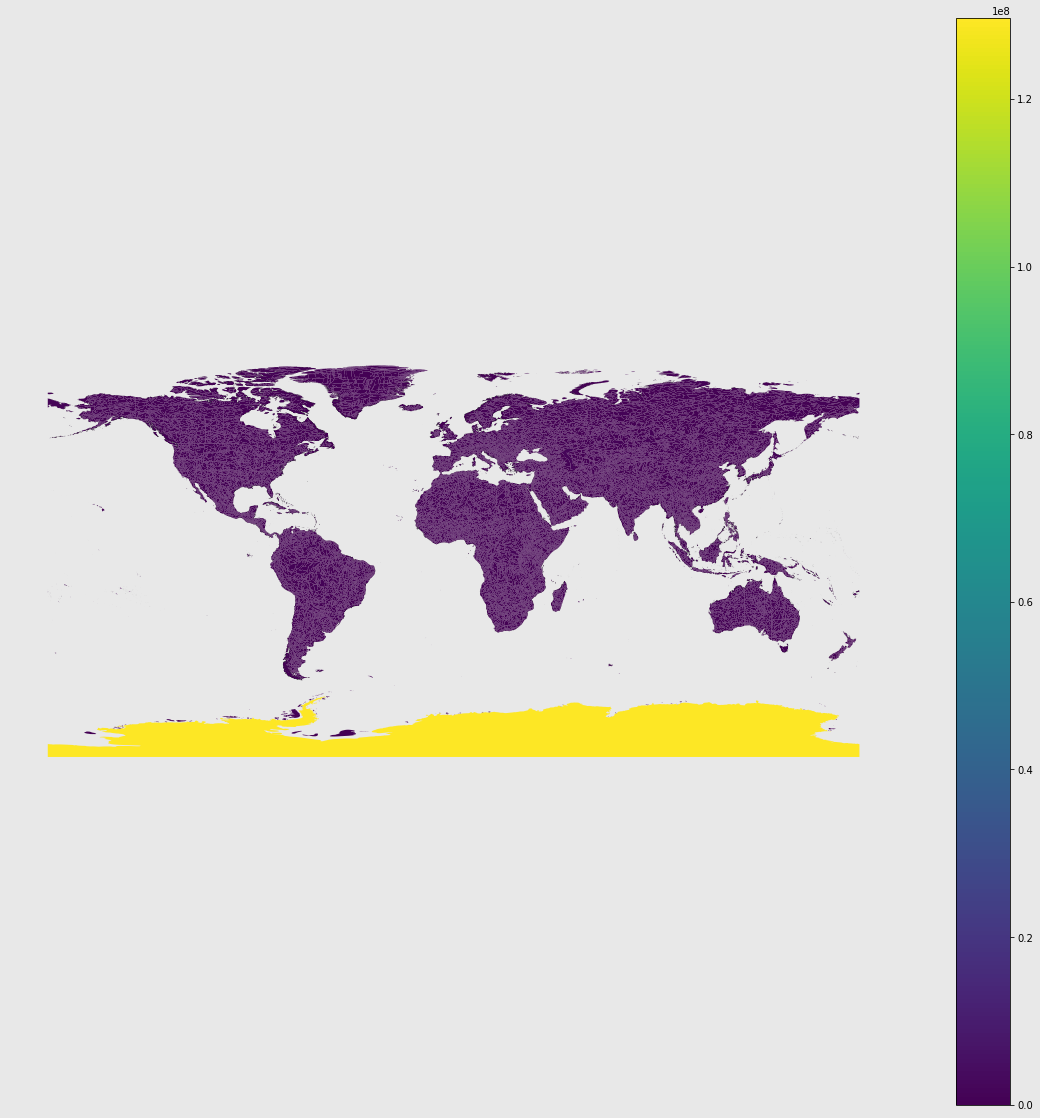

In [91]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='#E8E8E8')
aq.plot(ax = ax, column = 'sum_ghs', legend=True)
ax.set_axis_off()

# it doesn't look good

## Engineer Features

## Save GeoJSON for Modeling